In [1]:
import sys
sys.path.append("../") 

In [2]:
import argparse, time, logging, random, math

import numpy as np
import mxnet as mx

from mxnet import gluon, nd
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.,1.)
])

In [4]:
num_gpus = 1
model_ctx = mx.gpu()

num_workers = 4
batch_size = 256 
train_data = gluon.data.DataLoader(
    gluon.data.vision.MNIST(train=True).transform_first(transform),
    batch_size=batch_size, shuffle=True, last_batch='discard', num_workers=num_workers)

val_data = gluon.data.DataLoader(
    gluon.data.vision.MNIST(train=False).transform_first(transform),
    batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [5]:
for X,y in val_data:
    print(type(X))
    print(X.shape)
    print(y.shape)
    break

<class 'mxnet.ndarray.ndarray.NDArray'>
(256, 1, 28, 28)
(256,)


### Bayesian inference for MNIST

* [Stochastic Gradient Descent](#chapter1)
* [Stochastic Gradient Langevin Dynamics](#chapter2)
* [Bayes By Backprop](#chapter3)
* [Diagnostics](#chapter4)


# Stochastic Gradient Descent <a class="anchor" id="chapter1"></a>

In [6]:
import mxnet as mx
from mxnet import nd, autograd, gluon
hyper={'alpha':10.}
in_units=(28,28)
out_units=10

In [7]:
import mxnet as mx
from hamiltonian.inference.sgd import sgd
from hamiltonian.models.softmax import softmax

model=softmax(hyper,in_units,out_units,ctx=model_ctx)
inference=sgd(model,model.par,step_size=0.001,ctx=model_ctx)

In [8]:
import hamiltonian
import importlib

try:
    importlib.reload(hamiltonian.models.softmax)
    importlib.reload(hamiltonian.inference.sgd)
    print('modules re-loaded')
except:
    print('no modules loaded yet')


modules re-loaded


In [9]:
model.net.collect_params()

{'1.weight': Parameter (shape=(10, 784), dtype=float32),
 '1.bias': Parameter (shape=(10,), dtype=float32)}

  1%|          | 1/100 [00:07<11:55,  7.22s/it]

loss: 1.6005


 11%|█         | 11/100 [00:35<04:16,  2.88s/it]

loss: 0.4792


 21%|██        | 21/100 [01:04<04:04,  3.10s/it]

loss: 0.4130


 31%|███       | 31/100 [01:35<03:24,  2.96s/it]

loss: 0.3840


 41%|████      | 41/100 [02:03<02:46,  2.82s/it]

loss: 0.3667


 51%|█████     | 51/100 [02:32<02:20,  2.86s/it]

loss: 0.3546


 61%|██████    | 61/100 [03:00<01:50,  2.84s/it]

loss: 0.3458


 71%|███████   | 71/100 [03:31<01:28,  3.06s/it]

loss: 0.3388


 81%|████████  | 81/100 [04:00<00:54,  2.87s/it]

loss: 0.3331


 91%|█████████ | 91/100 [04:30<00:26,  2.97s/it]

loss: 0.3281


100%|██████████| 100/100 [05:02<00:00,  3.03s/it]


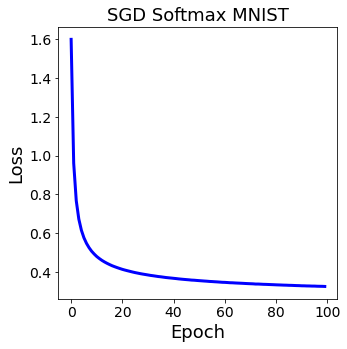

In [10]:
import matplotlib.pyplot as plt 
import h5py 

train_sgd=True
num_epochs=100
if train_sgd:
    par,loss=inference.fit(epochs=num_epochs,batch_size=batch_size,
                           data_loader=train_data,chain_name='mnist_map.h5',verbose=True)

    fig=plt.figure(figsize=[5,5])
    plt.plot(loss,color='blue',lw=3)
    plt.xlabel('Epoch', size=18)
    plt.ylabel('Loss', size=18)
    plt.title('SGD Softmax MNIST', size=18)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.savefig('sgd_softmax.pdf', bbox_inches='tight')
else:
    map_estimate=h5py.File('mnist_map.h5','r')
    par={var:map_estimate[var][:] for var in map_estimate.keys()}
    map_estimate.close()


In [11]:
from sklearn.metrics import classification_report

total_samples,total_labels,log_like=inference.predict(par,batch_size=batch_size,num_samples=100,data_loader=val_data)
y_hat=np.quantile(total_samples,.5,axis=0)
print(classification_report(np.int32(total_labels),np.int32(y_hat)))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       979
           1       0.98      0.97      0.97      1133
           2       0.92      0.88      0.90      1030
           3       0.88      0.90      0.89      1008
           4       0.91      0.93      0.92       980
           5       0.84      0.87      0.85       890
           6       0.92      0.95      0.93       956
           7       0.89      0.92      0.90      1027
           8       0.87      0.86      0.86       973
           9       0.92      0.85      0.88      1008

    accuracy                           0.91      9984
   macro avg       0.91      0.91      0.91      9984
weighted avg       0.91      0.91      0.91      9984



# Stochastic Gradient Langevin Dynamics <a class="anchor" id="chapter2"></a>

In [12]:
from hamiltonian.inference.sgld import sgld

model=softmax(hyper,in_units,out_units,ctx=model_ctx)
inference=sgld(model,par,step_size=0.001,ctx=model_ctx)

In [13]:
import hamiltonian
import importlib

try:
    importlib.reload(hamiltonian.models.softmax)
    importlib.reload(hamiltonian.inference.sgld)
    print('modules re-loaded')
except:
    print('no modules loaded yet')

modules re-loaded


  1%|          | 1/100 [00:03<06:35,  4.00s/it]

loss: 0.3657


 11%|█         | 11/100 [00:36<04:47,  3.23s/it]

loss: 0.3997


 21%|██        | 21/100 [01:08<04:13,  3.20s/it]

loss: 0.3830


 31%|███       | 31/100 [01:41<03:53,  3.39s/it]

loss: 0.3761


 41%|████      | 41/100 [02:14<03:09,  3.22s/it]

loss: 0.3647


 51%|█████     | 51/100 [02:45<02:30,  3.08s/it]

loss: 0.3540


 61%|██████    | 61/100 [03:16<02:01,  3.11s/it]

loss: 0.3469


 71%|███████   | 71/100 [03:49<01:39,  3.43s/it]

loss: 0.3454


 81%|████████  | 81/100 [04:20<00:59,  3.11s/it]

loss: 0.3423


 91%|█████████ | 91/100 [04:51<00:29,  3.32s/it]

loss: 0.3380


  1%|          | 1/100 [00:03<05:46,  3.50s/it]

loss: 0.3652


 11%|█         | 11/100 [00:38<04:51,  3.28s/it]

loss: 0.3939


 21%|██        | 21/100 [01:11<04:21,  3.31s/it]

loss: 0.3854


 31%|███       | 31/100 [01:44<03:47,  3.30s/it]

loss: 0.3722


 41%|████      | 41/100 [02:19<03:24,  3.46s/it]

loss: 0.3640


 51%|█████     | 51/100 [02:55<03:07,  3.82s/it]

loss: 0.3584


 61%|██████    | 61/100 [03:29<02:14,  3.44s/it]

loss: 0.3545


 71%|███████   | 71/100 [04:02<01:36,  3.32s/it]

loss: 0.3520


 81%|████████  | 81/100 [04:42<01:13,  3.87s/it]

loss: 0.3468


 91%|█████████ | 91/100 [05:15<00:30,  3.35s/it]

loss: 0.3432


100%|██████████| 100/100 [05:45<00:00,  3.46s/it]


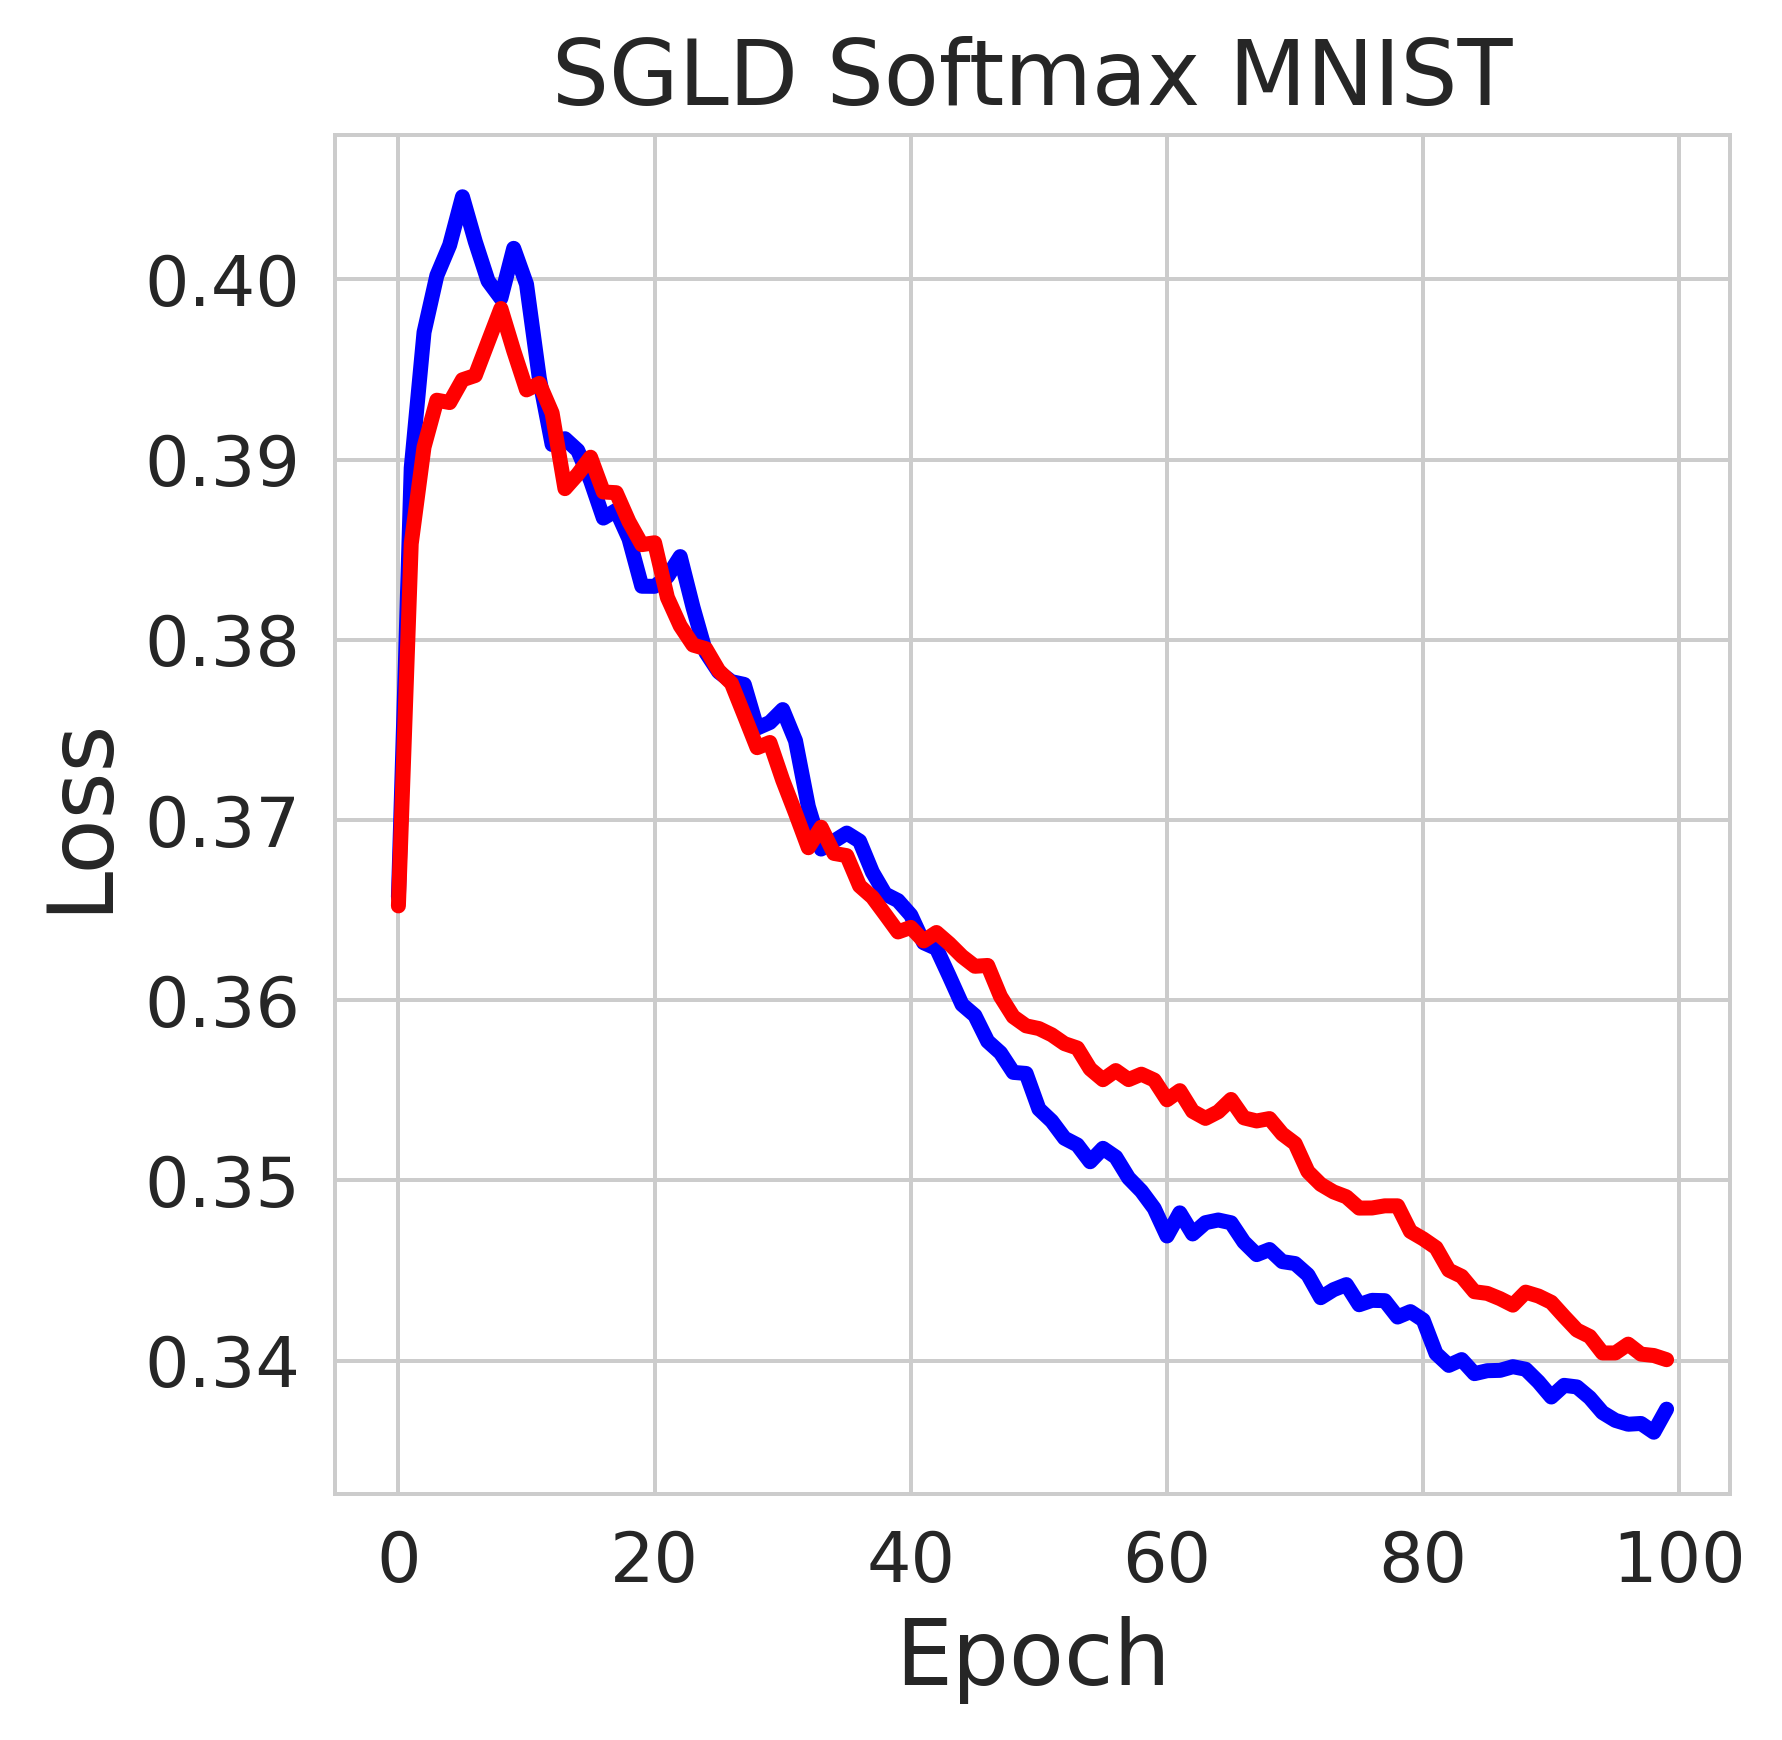

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import glob

train_sgld=True
num_epochs=100

if train_sgld:
    loss,posterior_samples=inference.sample(epochs=num_epochs,batch_size=batch_size,
                                data_loader=train_data,
                                verbose=True,chain_name='mnist_nonhierarchical.h5')

    plt.rcParams['figure.dpi'] = 360
    sns.set_style("whitegrid")
    fig=plt.figure(figsize=[5,5])
    plt.plot(loss[0],color='blue',lw=3)
    plt.plot(loss[1],color='red',lw=3)
    plt.xlabel('Epoch', size=18)
    plt.ylabel('Loss', size=18)
    plt.title('SGLD Softmax MNIST', size=18)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.savefig('sgld_softmax.pdf', bbox_inches='tight')

In [99]:
import h5py 

posterior_samples=h5py.File('mnist_nonhierarchical.h5','r')

In [100]:
posterior_samples.attrs.keys()

<KeysViewHDF5 ['loss', 'num_chains', 'num_samples']>

In [17]:
from sklearn.metrics import classification_report

total_samples,total_labels,log_like=inference.predict(posterior_samples,data_loader=val_data)
y_hat=np.quantile(total_samples,.5,axis=0)
print(classification_report(np.int32(total_labels),np.int32(y_hat)))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       980
           1       0.97      0.97      0.97      1135
           2       0.93      0.88      0.91      1032
           3       0.89      0.91      0.90      1010
           4       0.90      0.92      0.91       982
           5       0.84      0.87      0.85       892
           6       0.92      0.94      0.93       958
           7       0.90      0.92      0.91      1028
           8       0.86      0.85      0.86       974
           9       0.93      0.86      0.89      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [101]:
import tensorflow as tf
import tensorflow_probability as tfp

samples={var:posterior_samples[var] for var in posterior_samples.keys()}
samples={var:np.swapaxes(samples[var],0,1) for var in model.par}
r_hat_estimate = lambda samples : tfp.mcmc.diagnostic.potential_scale_reduction(samples, independent_chain_ndims=1,split_chains=False).numpy()
rhat = {var:r_hat_estimate(samples[var]) for var in model.par}

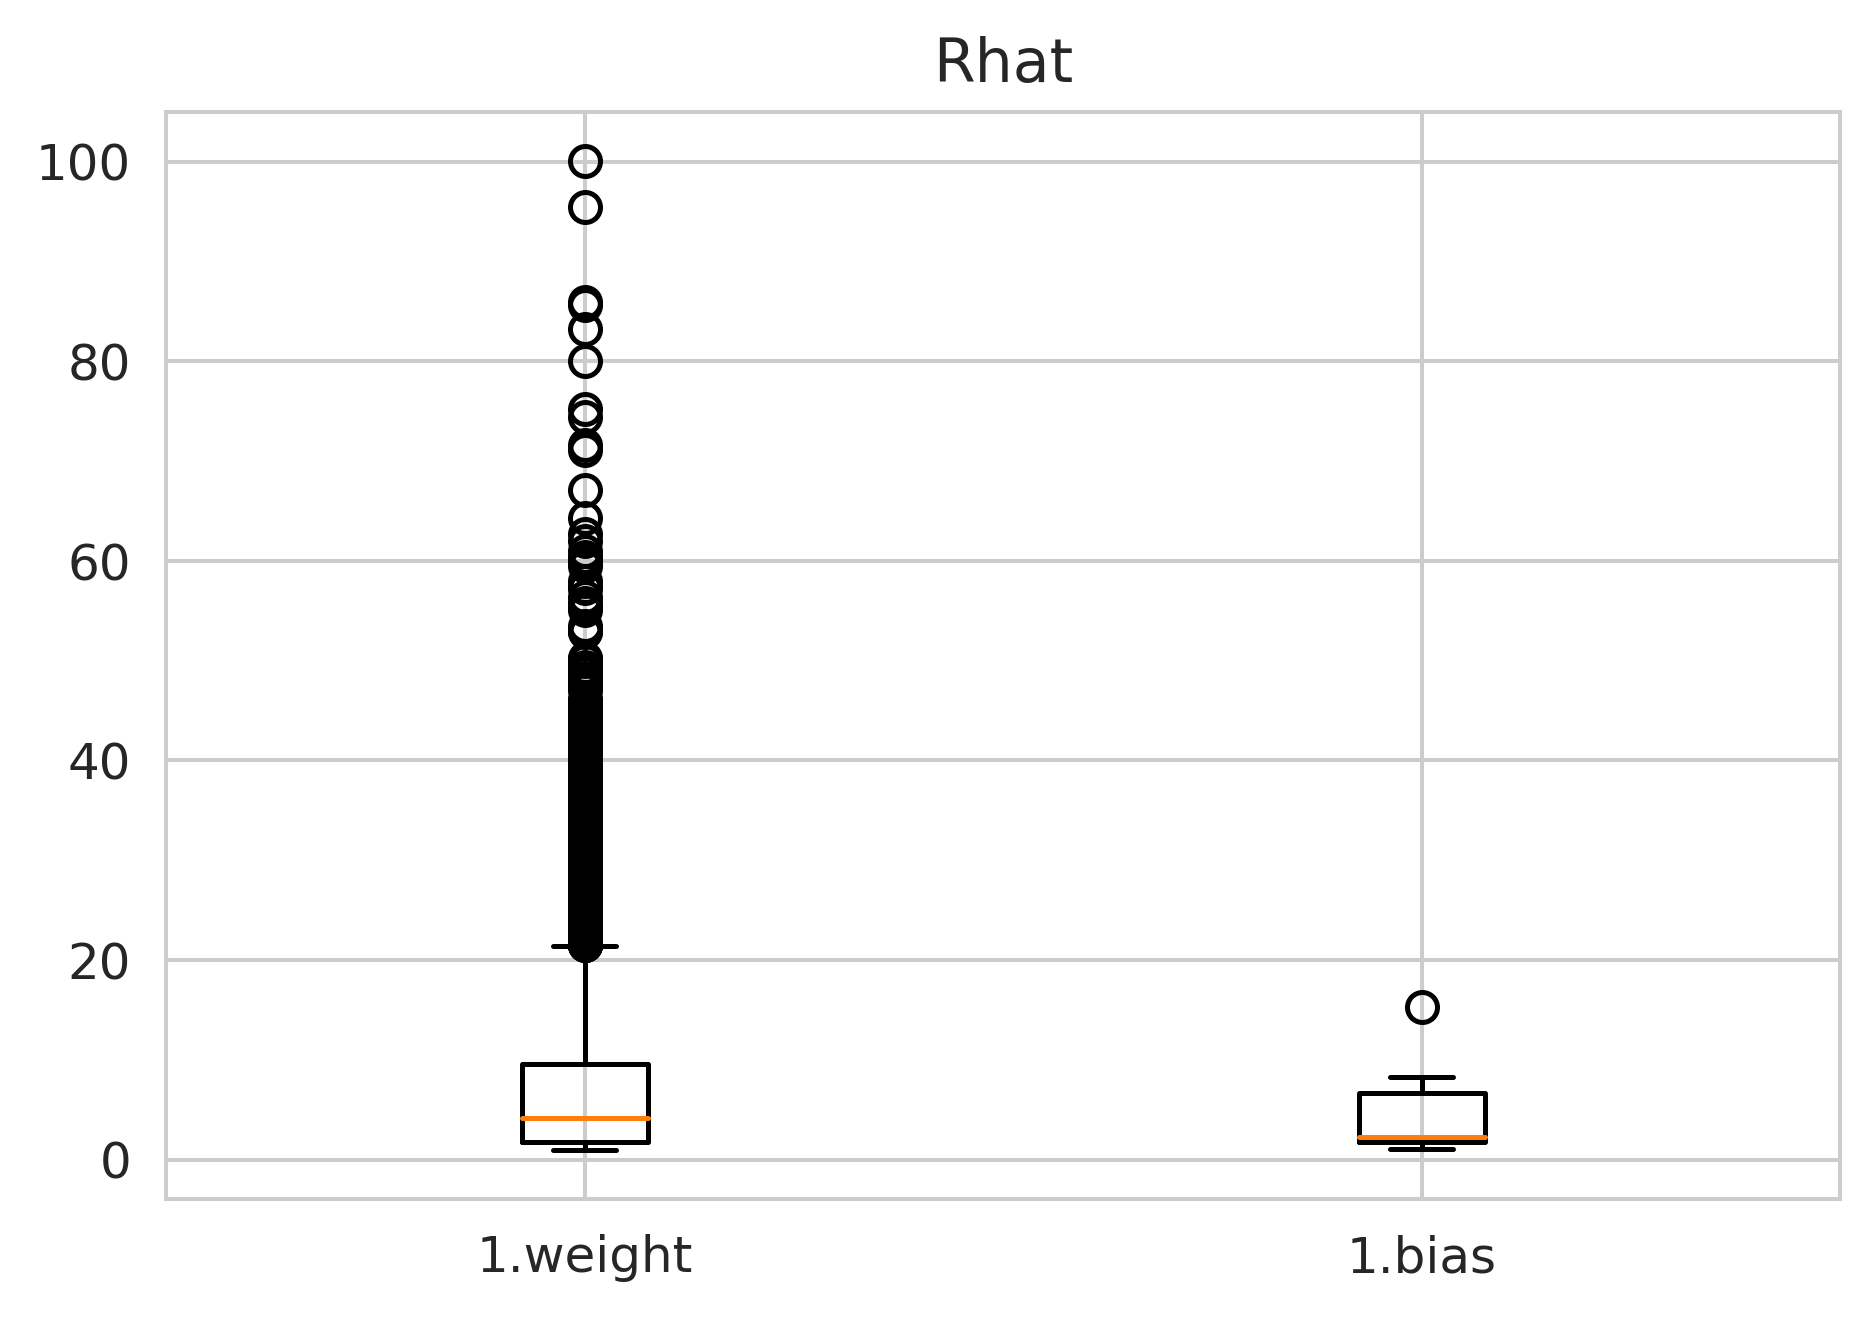

In [102]:
labels, data = rhat.keys(), rhat.values()
flatten_data=list()
for d in data:
    flatten_data.append(d.reshape(-1))
    
plt.boxplot(flatten_data)
plt.xticks(range(1, len(labels) + 1), labels)
plt.title('Rhat')
plt.savefig('rhat_nonhierarchical_softmax.pdf', bbox_inches='tight')

In [103]:
ess_estimate = lambda samples : tfp.mcmc.diagnostic.effective_sample_size(samples, filter_beyond_positive_pairs=False,cross_chain_dims=1).numpy()
ess = {var:ess_estimate(samples[var]) for var in model.par}

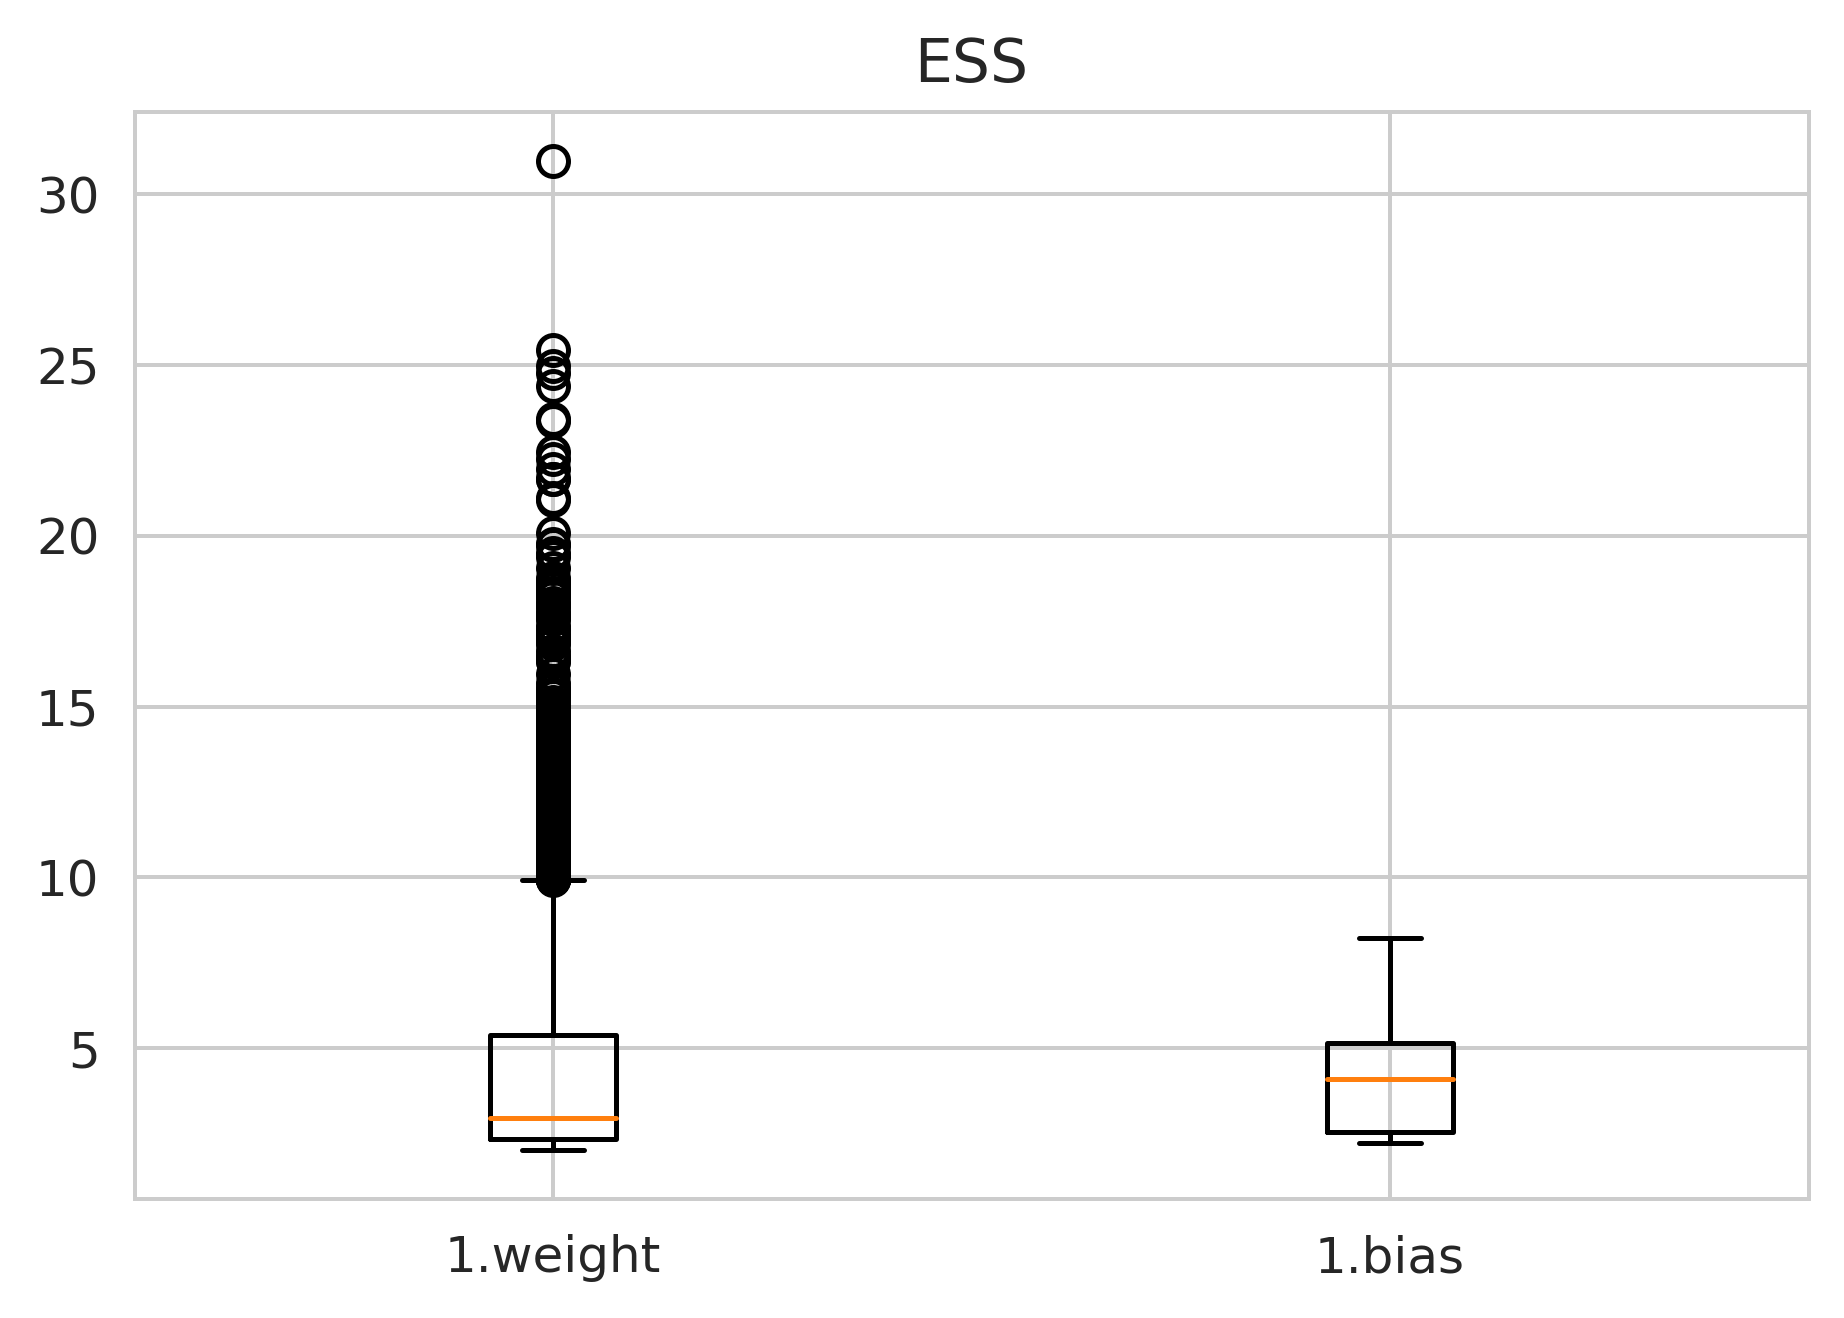

In [104]:
labels, data = ess.keys(), ess.values()
flatten_data=list()
for d in data:
    flatten_data.append(d.reshape(-1))
    
plt.boxplot(flatten_data)
plt.xticks(range(1, len(labels) + 1), labels)
plt.title('ESS')
plt.savefig('ess_nonhierarchical_softmax.pdf', bbox_inches='tight')

In [42]:
import dask.array as da 
from hamiltonian.utils.diagnostics import potential_scale_reduction,effective_sample_size

df=h5py.File('mnist_nonhierarchical.h5','r')
samples={var:da.from_array(df[var]) for var in df.keys()}
r_hat_estimate={var:potential_scale_reduction(samples[var]) for var in samples.keys()}
ess_estimate={var:effective_sample_size(samples[var]) for var in samples.keys()}

In [46]:
import arviz as az

samples={var:posterior_samples[var] for var in posterior_samples.keys()}
dataset=az.convert_to_inference_data(samples)

In [47]:
dataset

Inference data with groups:
	> posterior

In [48]:
mean_r_hat_values={var:float(az.rhat(dataset)[var].median().data) for var in model.par}
mean_ess_values={var:float(az.ess(dataset)[var].median().data) for var in model.par}
mean_mcse_values={var:float(az.mcse(dataset)[var].median().data) for var in model.par}

In [52]:
print(mean_r_hat_values)

{'1.weight': 1.8301109317465483, '1.bias': 1.7254156152362206}


In [54]:
mean_ess_values

{'1.weight': 3.1674032226610622, '1.bias': 3.3348590652833074}

In [55]:
from hamiltonian.utils.psis import *

loo,loos,ks=psisloo(log_like)

In [57]:
max(f1_score)

inf

In [62]:
max_ks=max(ks[~ np.isinf(ks)])

In [63]:
ks[np.isinf(ks)]=max_ks

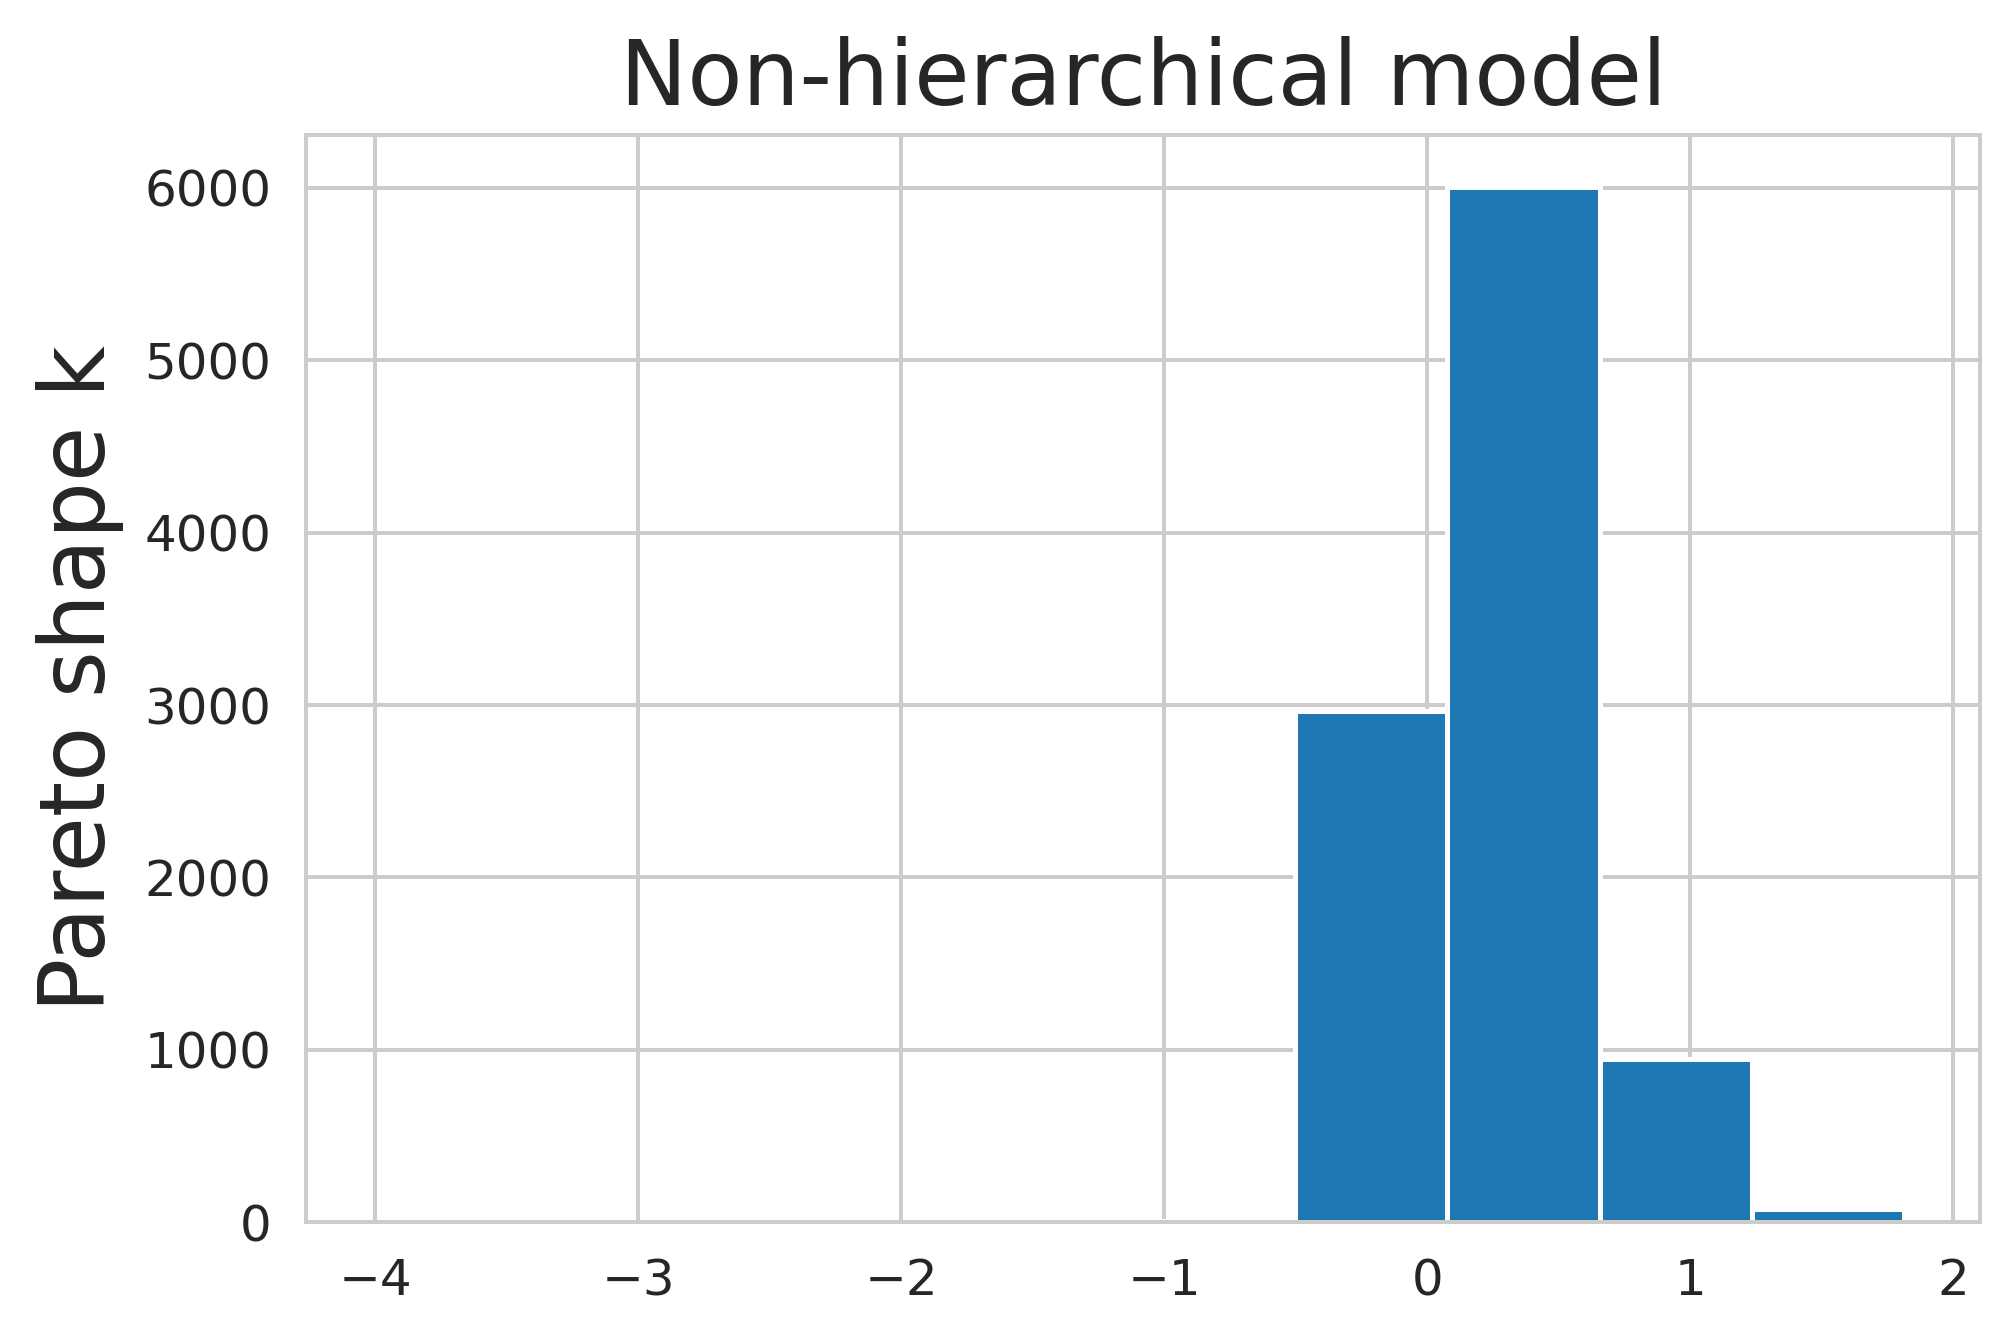

In [67]:
plt.hist(ks)
plt.ylabel('Pareto shape k', size=18)
plt.title('Non-hierarchical model', size=18)
plt.savefig('psis_sgld_softmax.pdf', bbox_inches='tight')

In [65]:
from sklearn.metrics import f1_score

score=[]
for q in np.arange(.1,.9,.1):
    y_hat=np.quantile(total_samples,q,axis=0)
    score.append(f1_score(np.int32(total_labels),np.int32(y_hat), sample_weight=1-np.clip(ks,0,1),average='weighted'))
print('mean f-1 : {0}, std f-1 : {1}'.format(np.mean(score),2*np.std(score)))

mean f-1 : 0.8730885613022314, std f-1 : 0.06614248990405727


In [68]:
np.sum(ks>1)

231

In [69]:
ks[np.logical_and(ks>0.7,ks<1)].sum()

513.1804138258237

In [70]:
ks[np.logical_and(ks>0.5,ks<0.7)].sum()

585.0296361948357

In [71]:
np.sum(ks<0.5)

8149

# Hierarchical Softmax <a class="anchor" id="chapter3"></a>

In [72]:
from hamiltonian.models.softmax import hierarchical_softmax
from hamiltonian.inference.sgld import sgld

model=hierarchical_softmax(hyper,in_units,out_units,ctx=model_ctx)
inference=sgld(model,par,step_size=0.001,ctx=model_ctx)

  1%|          | 1/100 [00:04<07:43,  4.68s/it]

loss: 0.4767


 11%|█         | 11/100 [00:48<06:33,  4.42s/it]

loss: 0.5005


 21%|██        | 21/100 [01:33<06:08,  4.66s/it]

loss: 0.5200


 31%|███       | 31/100 [02:14<04:40,  4.07s/it]

loss: 0.6889


 41%|████      | 41/100 [02:54<03:58,  4.05s/it]

loss: 0.4522


 51%|█████     | 51/100 [03:36<03:32,  4.33s/it]

loss: 0.4410


 61%|██████    | 61/100 [04:17<02:37,  4.04s/it]

loss: 0.5917


 71%|███████   | 71/100 [04:57<01:56,  4.01s/it]

loss: 0.4485


 81%|████████  | 81/100 [05:39<01:20,  4.24s/it]

loss: 0.4323


 91%|█████████ | 91/100 [06:19<00:36,  4.04s/it]

loss: 0.4848


  1%|          | 1/100 [00:04<06:37,  4.02s/it]

loss: 0.4509


 11%|█         | 11/100 [00:46<06:18,  4.25s/it]

loss: 0.4931


 21%|██        | 21/100 [01:28<05:25,  4.12s/it]

loss: 0.5107


 31%|███       | 31/100 [02:09<04:44,  4.13s/it]

loss: 0.4555


 41%|████      | 41/100 [02:52<04:10,  4.25s/it]

loss: 0.4786


 51%|█████     | 51/100 [03:33<03:19,  4.07s/it]

loss: 0.5244


 61%|██████    | 61/100 [04:14<02:37,  4.04s/it]

loss: 0.4625


 71%|███████   | 71/100 [04:56<01:59,  4.11s/it]

loss: 0.4461


 81%|████████  | 81/100 [05:37<01:17,  4.06s/it]

loss: 0.4361


 91%|█████████ | 91/100 [06:18<00:36,  4.07s/it]

loss: 0.4522


100%|██████████| 100/100 [06:56<00:00,  4.17s/it]


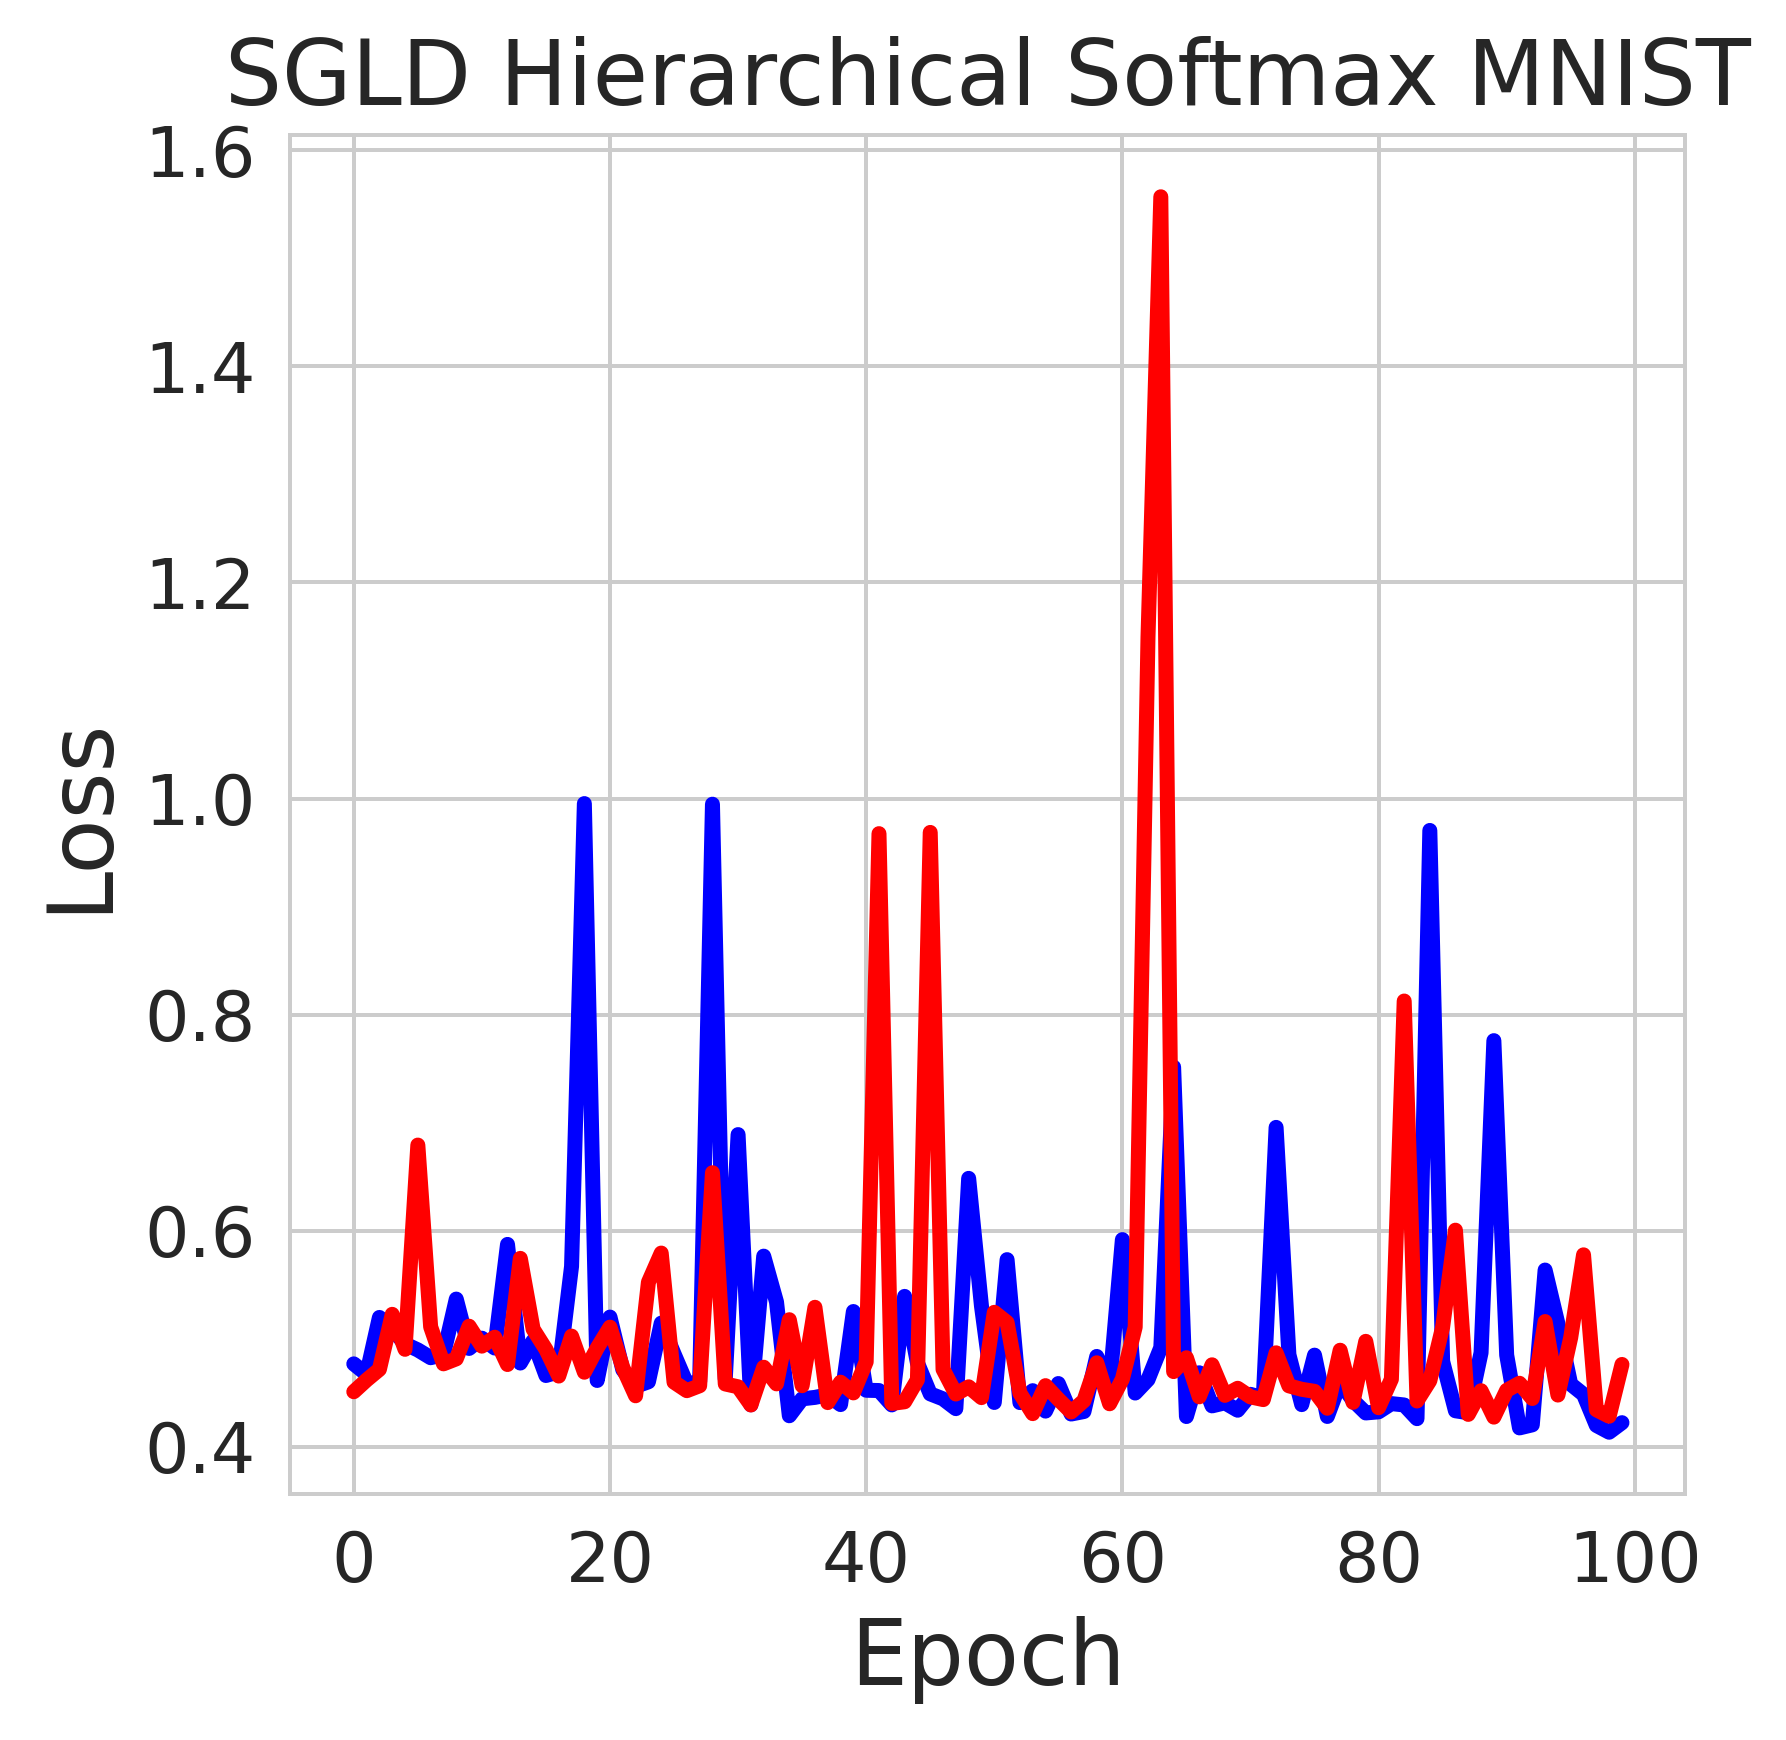

In [74]:
train_sgld=True
num_epochs=100

if train_sgld:
    loss,posterior_samples=inference.sample(epochs=num_epochs,batch_size=batch_size,
                                data_loader=train_data,
                                verbose=True,chain_name='mnist_hierarchical.h5')

    plt.rcParams['figure.dpi'] = 360
    sns.set_style("whitegrid")
    fig=plt.figure(figsize=[5,5])
    plt.plot(loss[0],color='blue',lw=3)
    plt.plot(loss[1],color='red',lw=3)
    plt.xlabel('Epoch', size=18)
    plt.ylabel('Loss', size=18)
    plt.title('SGLD Hierarchical Softmax MNIST', size=18)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.savefig('sgld_hierarchical_softmax.pdf', bbox_inches='tight')


In [112]:
import h5py 

posterior_samples=h5py.File('mnist_hierarchical.h5','r')

In [76]:
from sklearn.metrics import classification_report

total_samples,total_labels,log_like=inference.predict(posterior_samples,data_loader=val_data)
y_hat=np.quantile(total_samples,.5,axis=0)
print(classification_report(np.int32(total_labels),np.int32(y_hat)))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       980
           1       0.98      0.97      0.97      1135
           2       0.93      0.88      0.90      1032
           3       0.88      0.90      0.89      1010
           4       0.92      0.92      0.92       982
           5       0.86      0.87      0.86       892
           6       0.92      0.95      0.93       958
           7       0.90      0.92      0.91      1028
           8       0.86      0.87      0.86       974
           9       0.92      0.87      0.89      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [113]:
import tensorflow as tf
import tensorflow_probability as tfp

samples={var:posterior_samples[var] for var in posterior_samples.keys()}
samples={var:np.swapaxes(samples[var],0,1) for var in model.par}
r_hat_estimate = lambda samples : tfp.mcmc.diagnostic.potential_scale_reduction(samples, independent_chain_ndims=1,split_chains=False).numpy()
rhat = {var:r_hat_estimate(samples[var]) for var in model.par}

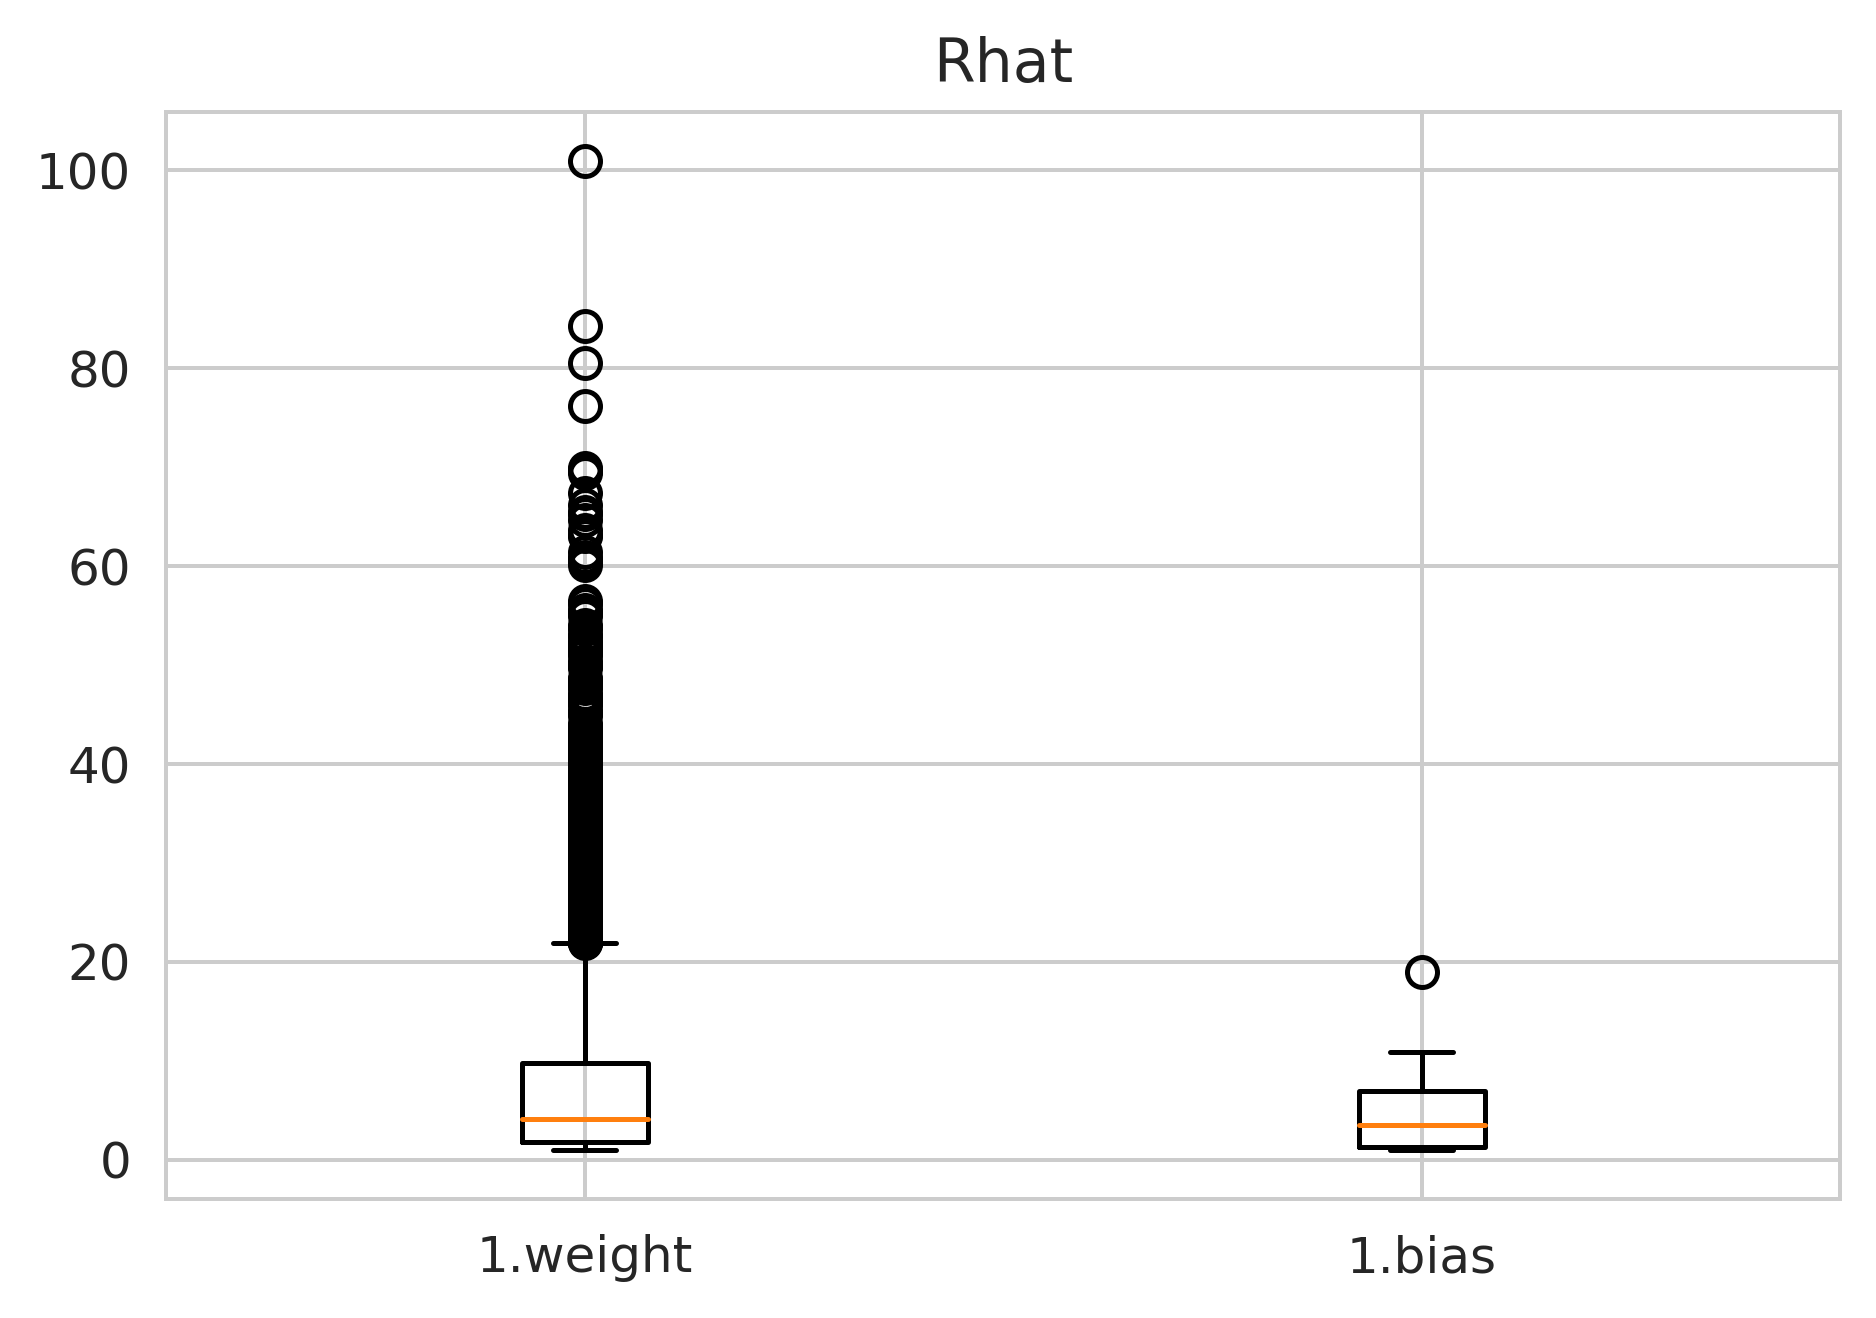

In [114]:
labels, data = rhat.keys(), rhat.values()
flatten_data=list()
for d in data:
    flatten_data.append(d.reshape(-1))
    
plt.boxplot(flatten_data)
plt.xticks(range(1, len(labels) + 1), labels)
plt.title('Rhat')
plt.savefig('rhar_hierarchical_softmax.pdf', bbox_inches='tight')

In [115]:
ess_estimate = lambda samples : tfp.mcmc.diagnostic.effective_sample_size(samples, filter_beyond_positive_pairs=False,cross_chain_dims=1).numpy()
ess = {var:ess_estimate(samples[var]) for var in model.par}

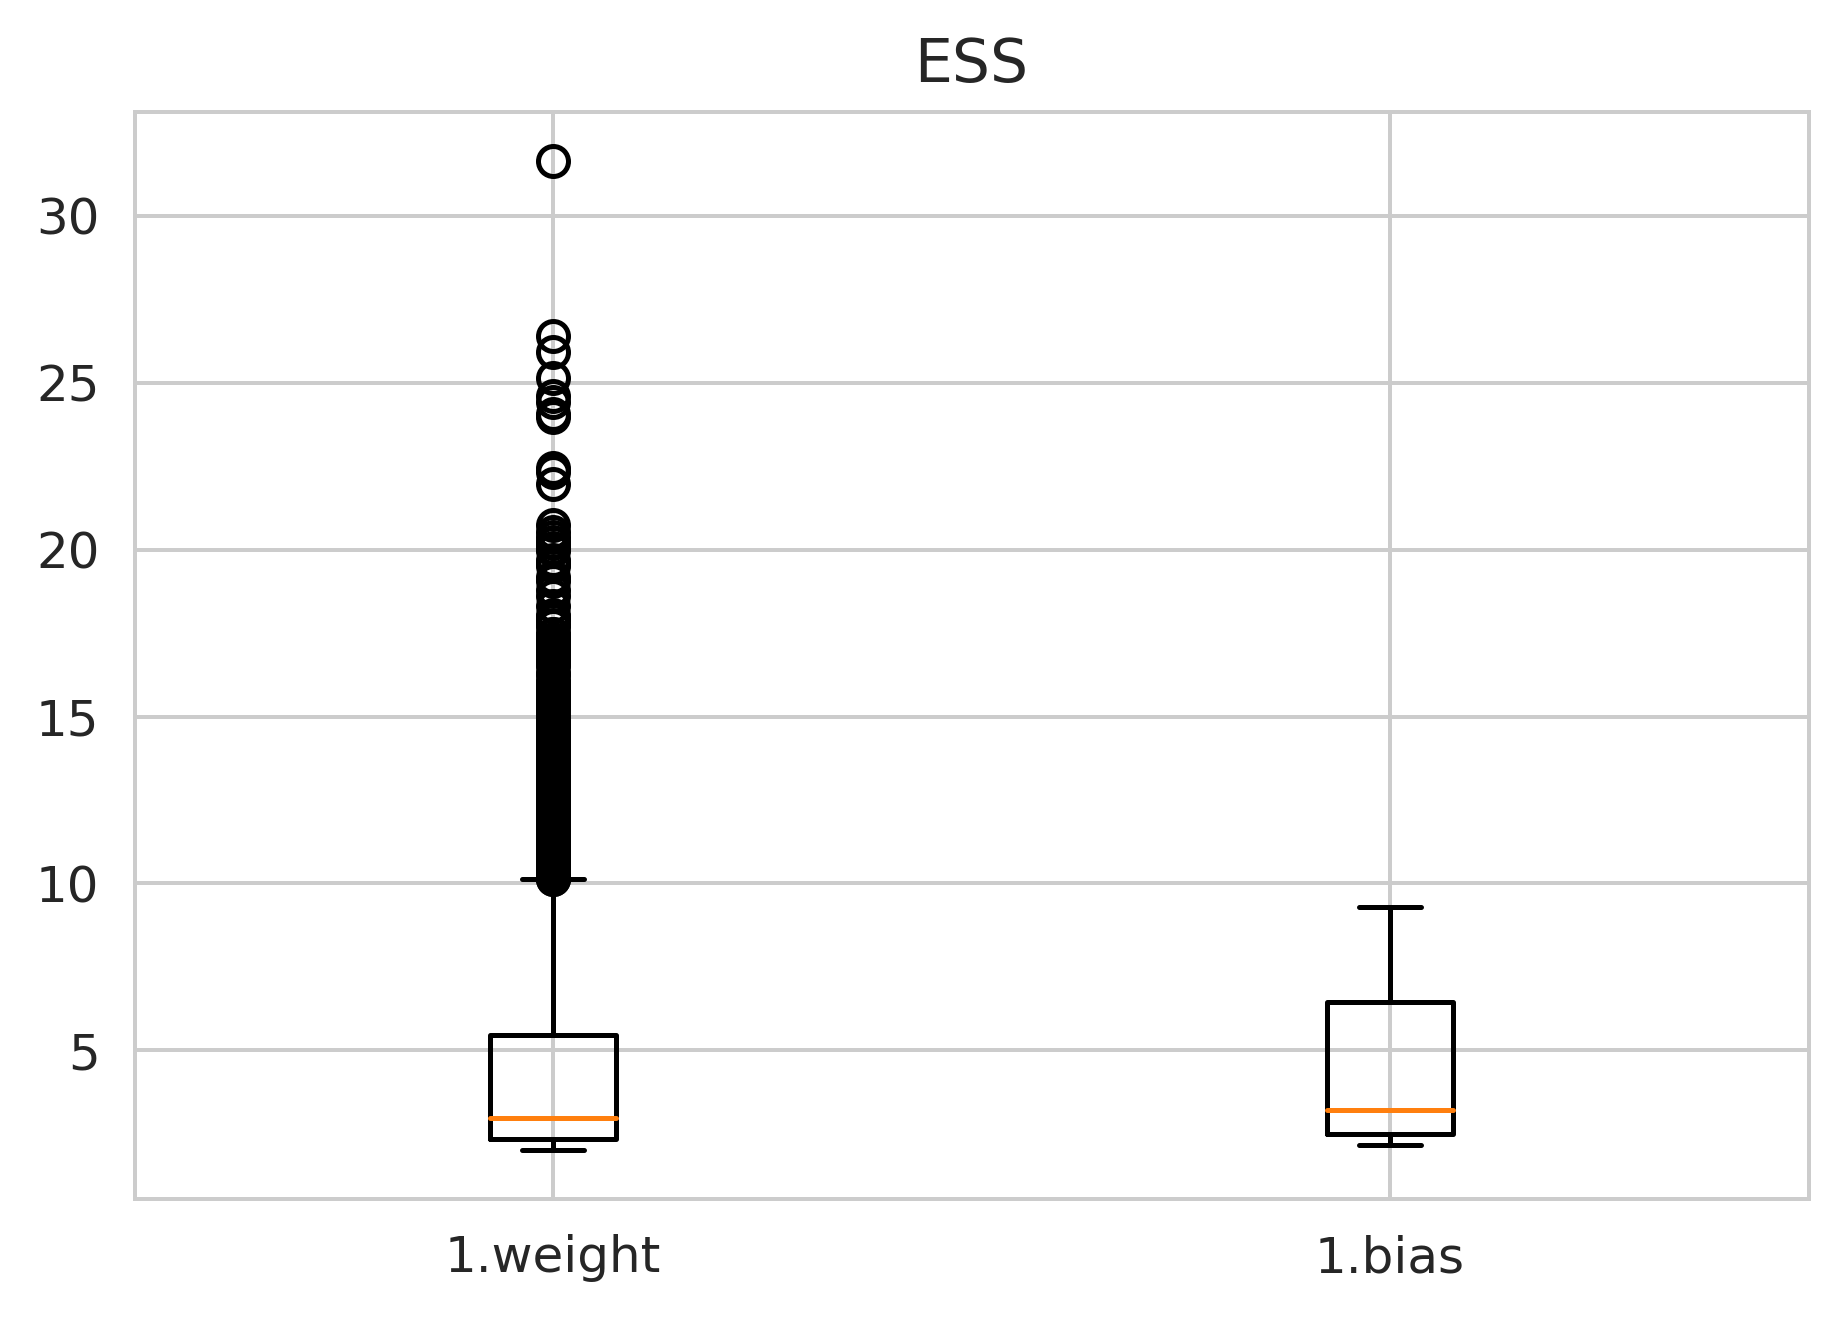

In [116]:
labels, data = ess.keys(), ess.values()
flatten_data=list()
for d in data:
    flatten_data.append(d.reshape(-1))
    
plt.boxplot(flatten_data)
plt.xticks(range(1, len(labels) + 1), labels)
plt.title('ESS')
plt.savefig('ess_hierarchical_softmax.pdf', bbox_inches='tight')

In [83]:
from hamiltonian.utils.psis import *

loo,loos,ks=psisloo(log_like)

In [87]:
max_ks=max(ks[~ np.isinf(ks)])
ks[np.isinf(ks)]=max_ks

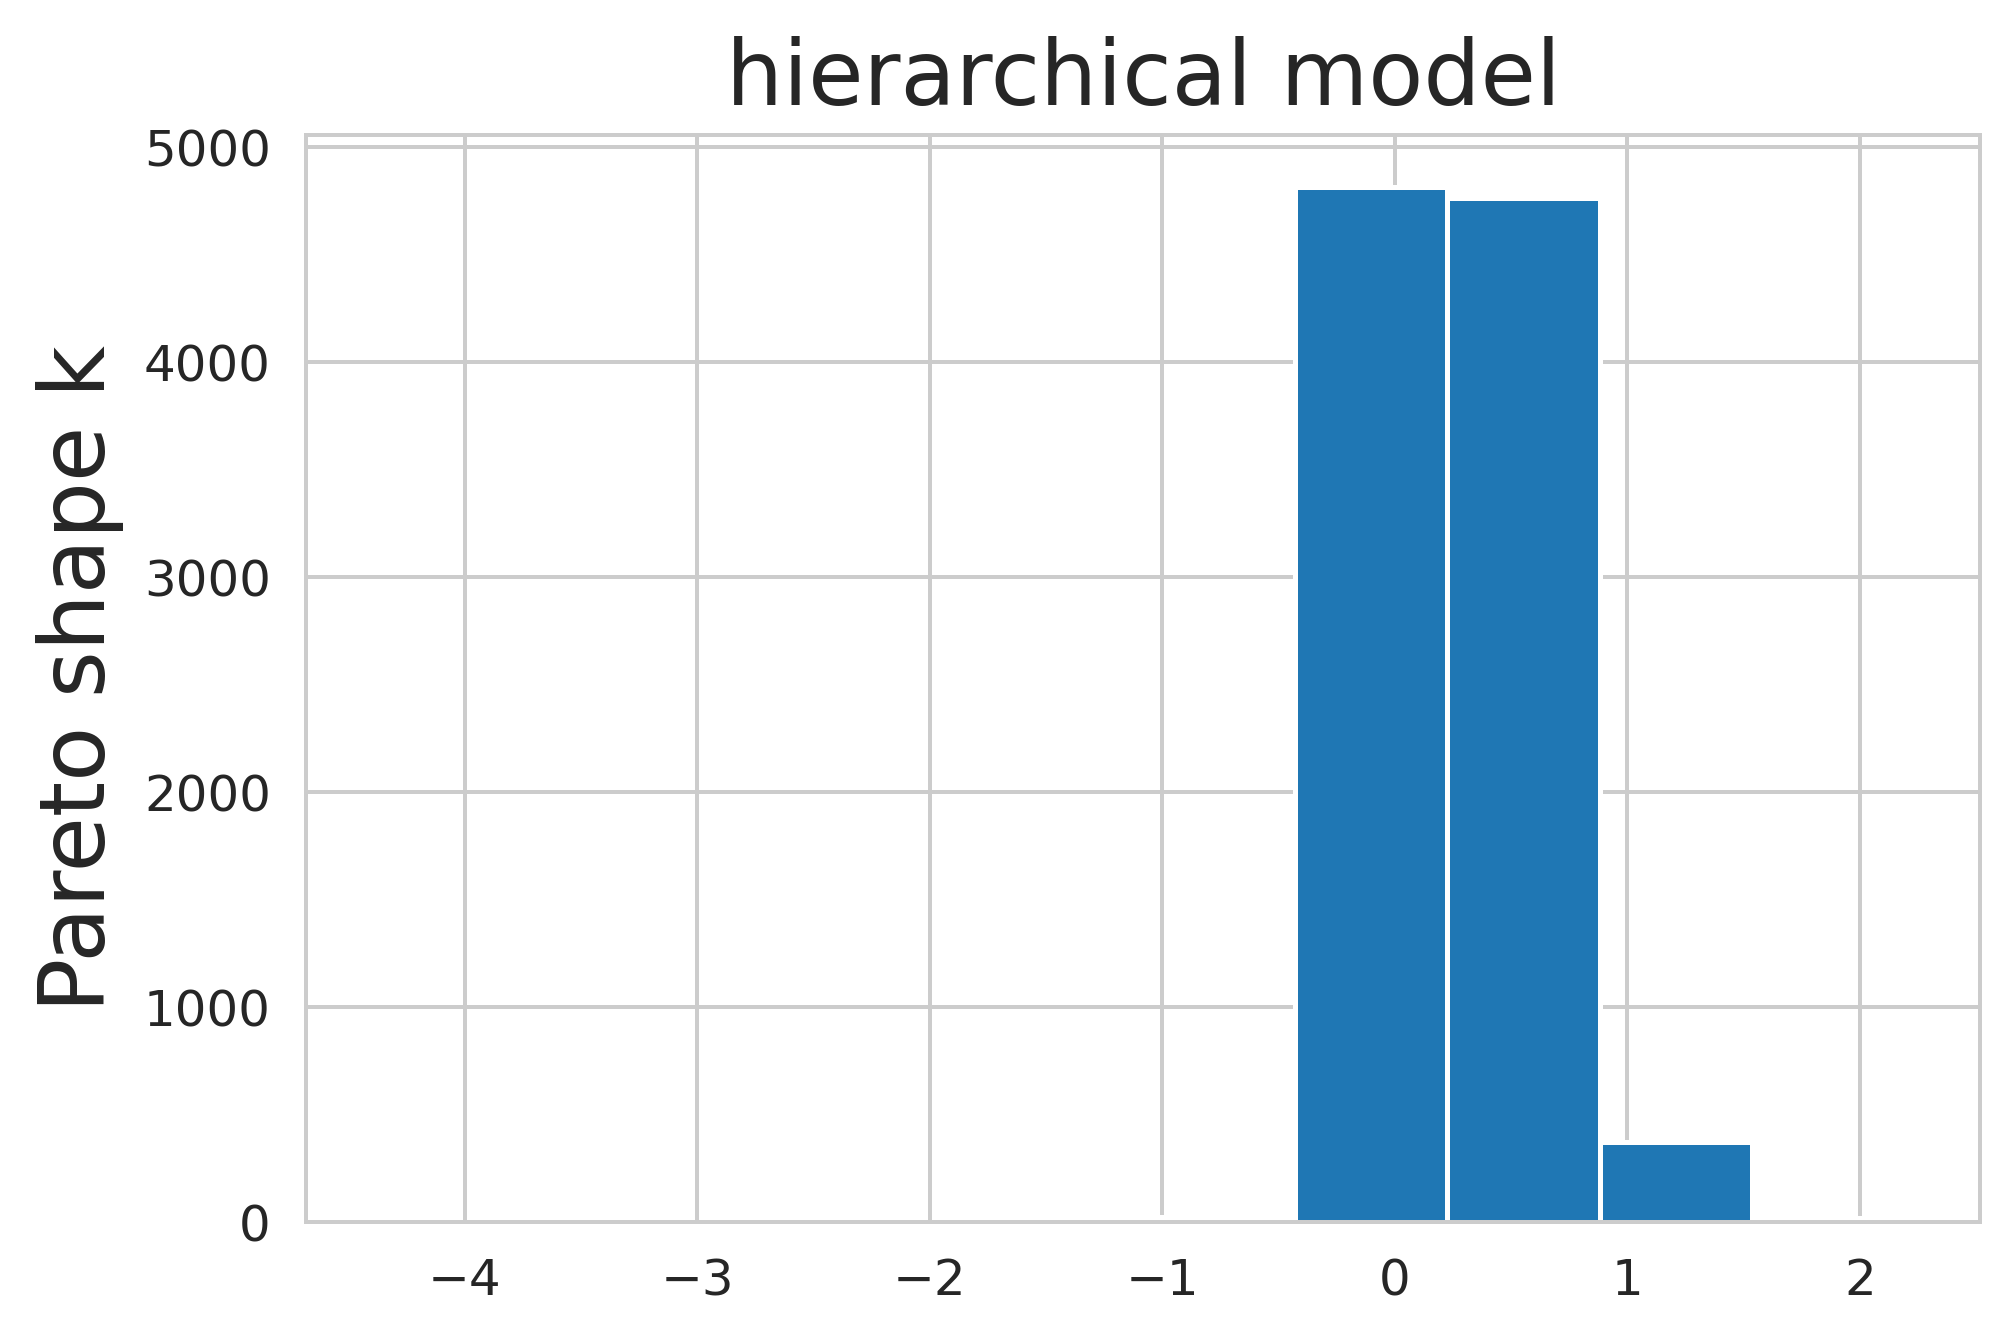

In [88]:
plt.hist(ks)
plt.ylabel('Pareto shape k', size=18)
plt.title('hierarchical model', size=18)
plt.savefig('psis_sgld_softmax_hierarchical.pdf')

In [89]:
np.sum(ks>1)

213

In [90]:
ks[np.logical_and(ks>0.7,ks<1)].sum()

533.3344394085359

In [91]:
ks[np.logical_and(ks>0.5,ks<0.7)].sum()

649.7082900472562

In [92]:
np.sum(ks<0.5)

8032